In [1]:
%matplotlib inline
import bioscrape as bs
import numpy as np
import pylab as plt

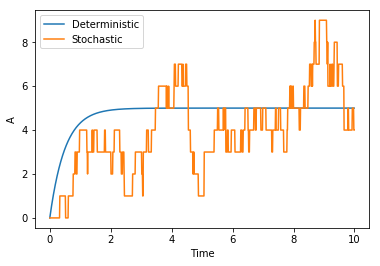

In [2]:
#rxn = ([INTPUS], [OUTPUTS], "propensity type", {propensity parameters})
rxn1 = ([], ["A"], "massaction", {"k":10.})
rxn2 = (["A"], [], "massaction", {"k":2.})
x0 = {"A":0}
M = bs.types.Model(reactions = [rxn1, rxn2], initial_condition_dict = x0)
time = np.arange(0, 10, .01)

#Simple simulator wrappers return Pandas DataFrames
Rdet = bs.simulator.py_simulate_model(time, Model = M, stochastic = False)
Rsto = bs.simulator.py_simulate_model(time, Model = M, stochastic = True)

plt.figure()
plt.plot(time, Rdet["A"], label = "Deterministic")
plt.plot(time, Rsto["A"], label = "Stochastic")
plt.xlabel("Time")
plt.ylabel("A")
plt.legend()

In [3]:
import bioscrape.lineage as lineage
import time as pytime

#Define Rates
k = 1
d = .1
g = .2

#Define Reactions
rxn1 = (["A"], ["A", "X"], "massaction", {"k":k}) #A --> A + X @ k=k
rxn2 = (["A"], ["B"], "massaction", {"k":d}) #A --> B @ k=d
rxn3 = (["B"], ["A"], "massaction", {"k":d}) #B --> A @ k=d
rxns = [rxn1, rxn2, rxn3] #Define a list of all reactions

#Define initial condtion (as a dictionary)
x0 = {"X": 5, "A":1, "B":0}
#Instantiate Model
M = lineage.LineageModel(reactions = rxns, initial_condition_dict = x0)

#Add a volume event to the model (with a mass action propensity dependent on X). 
#Causes the volume to grow linearly by the amount g when event fires.
M.create_volume_event("linear volume", {"growth_rate":g}, "massaction", {"k":.1, "species":"X"})

#Create a Volume Splitter which determines how species are partitioned at division
#species A and B will be duplicated (as if they were genomic) and X will by default be partitioned binomially
vsplit = lineage.LineageVolumeSplitter(M, options = {"A":"duplicate", "B":"duplicate"})

#Cells divide automatically (Rule) if they have grown by 5 units
M.create_division_rule("deltaV", {"threshold":5}, vsplit)

#Cells have probability of dying of X is too low when in B state
M.create_death_event("death event", {}, "hillnegative", {"s1":"X", "K":3, "k":.01, "n":3})




In [4]:


ts = pytime.clock()
lineage = lineage.py_SimulateCellLineage(timepoints, Model = M)
te = pytime.clock()
print("Simulation done in", te-ts)

print("Creating Lineage Tree List")
sch_tree = [[]]
sch_tree_length = 1
for i in range(lineage.py_size()):
	sch = lineage.py_get_schnitz(i)
	if sch.py_get_parent() == None:
		sch_tree[0].append(sch)
	else:
		for j in range(len(sch_tree)):
			parent = sch.py_get_parent()
			if parent in sch_tree[j]:
				if len(sch_tree)<= j+1:
					sch_tree.append([])
					sch_tree_length += 1
				sch_tree[j+1].append(sch)

color_list = []
for i in range(sch_tree_length):
	color_list.append((i/sch_tree_length, 0, 1.-i/sch_tree_length))

print("Plotting")
#X_ind = LM1.get_species_index('X')
plt.figure()
#plt.subplot(211)
count = 0
for i in range(sch_tree_length):
    for sch in sch_tree[i]:
        df = sch.py_get_dataframe(Model = M)
        count+=1
        plt.plot(df["time"], df["X"], color = color_list[i])
plt.ylabel("X")
plt.xlabel("Time")
plt.title("Total Cells Simulated "+str(count)+" in "+str(round(te-ts, 5))+"s")

#plt.subplot(212)
plt.figure()
for i in range(sch_tree_length):
    for sch in sch_tree[i]:
        df = sch.py_get_dataframe(Model = M)
        plt.plot(df["time"], df["volume"], color = color_list[i])
plt.xlabel("time")
plt.ylabel("volume")
print("\n\nTotal Cells Simulated", count, "in", te-ts)

plt.show()

NameError: name 'timepoints' is not defined

In [ ]:
#Interacting Lineage
N = 20
M1 = lineage.LineageModel(file_name = "C:\\Users\\wp_ix\\OneDrive\\Caltech\\Code\\bioscrape lineages\\sbml models\\cell_to_cell_comm_model_1.xml")